<a href="https://colab.research.google.com/github/idjoopal/NLP_tensorflow2.0/blob/main/%EC%8B%A4%EC%8A%B5_2_Attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 야 나두 <번역> 할 수 있어

<b>학습 목표:    
- 번역 모델의 인풋 / 아웃풋 구조를 이해한다.
- Seq2Seq + attention 구조를 추가한 모델을 사용해본다.</b>








## #1. 실습 준비

이번 실습에서는 Seq2Seq + Attention 알고리즘을 사용한 번역 모델을 사용해 한국어-> 영어 번역을 체험해볼 것입니다. 

Attention 알고리즘은 그 결과를 시각화해볼 수 있는 재미있는 알고리즘이어서, 특히 시작화에 초점을 맞춰볼 것인데요.
Colab에 약간의 버그가 있어 한글 프린트가 한 번에 안 될 수 있으니 아래 스텝을 따라서 잘 진행해주세요!

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.


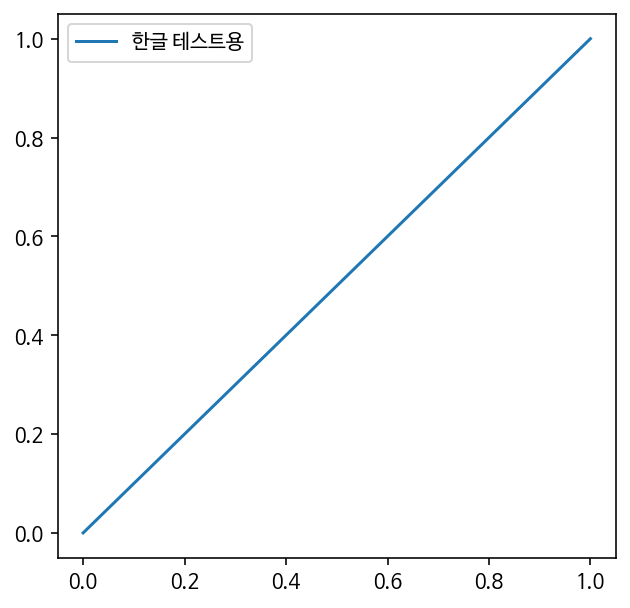

In [14]:
## 라이브러리 설치 & matplotlib 환경 설정
import matplotlib as mpl
import matplotlib.pyplot as plt
 
%config InlineBackend.figure_format = 'retina'
 
!apt -qq -y install fonts-nanum
 
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

plt.figure(figsize=(5,5))
plt.plot([0,1],[0,1],label="한글 테스트용")
plt.legend()
plt.show()

👉 위 코드를 실행하면 plot의 한글이 깨져서 나올 것입니다.   
👉 이제 상탄의 <런타임> - <런타임 다시 실행> 버튼을 누르고, 위의 코드를 다시 실행해 주세요.   
👉 '한글 테스트용'이라는 글씨가 제대로 프린트되었으면, 아래 실습을 진행해 나가시면 됩니다.   

필요한 라이브러리 설치 및 로딩

In [15]:
# 한국어 형태소 분석기 설치
!pip install konlpy

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras import layers

import numpy as np
import konlpy
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time

## #2. 데이터 준비하기

### Step 1. 데이터셋 다운로드 & 로딩   
번역 모델 학습에는 첫 번째 날에 AI HUB에서 신청한 한영 번역 말뭉치를 사용합니다.   
홈페이지에서 다운받은 엑셀 파일을 Colab 환경에 업로드해주세요.   
엑셀 파일이 용량이 커서 업로드에 시간이 소요될 수 있습니다.   

In [17]:
## 엑셀 파일 읽어오기
path_to_file = "/content/2_대화체_200226.xlsx"

import pandas as pd
data = pd.read_excel(path_to_file)

data

,대분류,소분류,상황,Set Nr.,발화자,원문,번역문
0,비즈니스,회의,의견 교환하기,1,A-1,이번 신제품 출시에 대한 시장의 반응은 어떤가요?,How is the market's reaction to the newly rele...
1,비즈니스,회의,의견 교환하기,1,B-1,판매량이 지난번 제품보다 빠르게 늘고 있습니다.,The sales increase is faster than the previous...
2,비즈니스,회의,의견 교환하기,1,A-2,그렇다면 공장에 연락해서 주문량을 더 늘려야겠네요.,"Then, we'll have to call the manufacturer and ..."
3,비즈니스,회의,의견 교환하기,1,B-2,"네, 제가 연락해서 주문량을 2배로 늘리겠습니다.","Sure, I'll make a call and double the volume o..."
4,비즈니스,회의,의견 교환하기,2,A-1,지난 회의 마지막에 논의했던 안건을 다시 볼까요?,Shall we take a look at the issues we discusse...
...,...,...,...,...,...,...,...
99995,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",24999,B-2,"저희가 가격표 배치를 잘못해서 혼동을 드렸나 봐요, 죄송해요.",It seems that we didn't place the price tags c...
99996,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-1,"백화점 포인트로 계산하고 싶은데, 가능한가요?",Can I pay using the department store points?
99997,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,B-1,"네, 물론이죠, 전화번호 입력해주시면 됩니다.","Yes, of course, you just need to enter your ph..."
99998,여행/쇼핑,쇼핑,"계산/포장/배달 (계산 장소 문의, 계산 오류 등)",25000,A-2,"입력했어요, 전액 백화점 포인트로 결제하고 싶어요.","I entered it, I want to pay it with all the de..."


👉 총 10만건의 한국어-영어 병렬 코퍼스가 들어있는 것을 확인할 수 있습니다.   
👉 <원문>과 <번역문> 컬럼에 들어있는 문장을 가지고 와서 데이터를 구성하겠습니다. 


<img src = "https://github.com/seungyounglim/temporary/blob/master/fig_step1.PNG?raw=true">   


In [18]:
## 한국어의 경우, 띄어쓰기가 아닌 형태소 단위로 분리하는 것이 좋음
from konlpy.tag import Komoran
kmr=Komoran()

def kor_tokenizer(lines):
  return " ".join([pos[0] for pos in kmr.pos(lines)])
kor_tokenizer("문장을 형태소단위로 나눠서 번역하기")

'문장 을 형태소 단위 로 나누 어서 번역 하 기'

기계번역도 마찬가지로 토크나이징-인코딩-토큰임베딩-모델링 과정을 진행하면 되는데요,   
데이터셋 전처리 부분은 미리 코딩을 해 두었으니 attention_codes.py 파일을 업로드하여 사용하시면 됩니다.   

In [20]:
from attention_codes import *

먼저 한국어는 형태소 분석을 진행하여 SOURCE, 영어는 띄어쓰기 단위를 그대로 사용해 TARGET에 불러옵니다.   
이때 번역에서 문장의 시작과 끝을 알려주기 위해 원본과 번역문 문장 앞뒤에 각각 <start> <end>라는 스페셜 토큰을 추가하였습니다. 

In [21]:
SOURCE, TARGET = create_dataset(path_to_file, kor_tokenizer)
print("데이터 개수:", len(SOURCE), len(TARGET))
print(SOURCE[-1])
print(TARGET[-1])

100%|██████████| 100000/100000 [00:50<00:00, 1983.67it/s]

데이터 개수: 100000 100000
<start> 죄송 하 지만 포인트 제외 하 ㄴ 차액 15 , 000 원 은 따로 결제 하 아 주 시 어야 하 ㅂ니다 . <end>
<start> I'm sorry, but you need to make a separate payment of 15,000 won, excluding the department store points. <end>


### Step 2. 토크나이징   
<img src = "https://github.com/seungyounglim/temporary/blob/master/fig_step2.PNG?raw=true">   

단어사전을 만들어 토큰화된 단어를 인코딩하는 부분도 attention_codes 내에 미리 코딩해둔 함수를 사용하겠습니다.  


In [22]:
## 데이터 불러오기
## inp_lang: Source(한국어) tokenizer
## targ_lang: Target(영어) tokenizer

input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(SOURCE, TARGET)

# 최대 길이 구하기
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

print("인풋 최대 길이:", max_length_inp)
print("타켓 최대 길이:", max_length_targ)

인풋 최대 길이: 88
타켓 최대 길이: 64


👉 input_tensor에는 한국어 문장, target_tensor에는 영어 문장이 각각의 단어사전으로 인코딩되어 들어있습니다.   
👉 인풋 한국어는 최대 88 토큰, 타겟 영어는 최대 64토큰을 가지고 있습니다.   
👉 꽤 긴 문장도 포함되어 있는 것이지요.   


In [23]:
## 인풋 예시
print(input_tensor[0])

[   2   95  793  683    7  247   12  837   57 1093   17   66   55    3
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0]


In [24]:
## 타겟 예시
print(target_tensor[0])

[    2    49    10     4 11345  2223     6     4  1270   749    94     3
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


👉 숫자는 비슷해 보이지만, 사실 input과 target은 각각  <한국어 단어사전>과 <영어 단어사전>을 사용해 인코딩한 결과입니다.   
👉 모델도 각기 다른 임베딩을 사용해 이 토큰들을 인식하게 됩니다.   

### Step 3. 학습-검증 데이터 나누기
학습을 위해 10만개의 문장을 각각 90000 - 10000개에 해당하는 학습/ 검증 데이터로 나누었습니다. 

In [25]:
# 8:2로 학습 - 검증 데이터 나누기
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.1, random_state=2020)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

90000 90000 10000 10000


(참고) 인덱스가 잘 만들어졌는지 확인해보기   
학습셋으로 나누어진 것에 대해 어떤 태스크를 수행하게 될지 한 번 확인해보겠습니다. 

In [26]:
def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [27]:
print ("인풋 문장 예시 :")
convert(inp_lang, input_tensor_train[0])
print ()
print ("타겟 문장 예시 :")
convert(targ_lang, target_tensor_train[0])

인풋 문장 예시 :
2 ----> <start>
273 ----> 얼마
143 ----> 전
227 ----> 카드
956 ----> 기계
9 ----> 가
765 ----> 고장
5 ----> 이
558 ----> 나서
15 ----> 어
384 ----> 현재
715 ----> 수리
141 ----> 중
5 ----> 이
19 ----> 어요
3 ----> <end>

타겟 문장 예시 :
2 ----> <start>
30 ----> my
144 ----> card
608 ----> machine
1459 ----> broke
228 ----> down
8 ----> a
377 ----> few
143 ----> days
309 ----> ago
12 ----> so
38 ----> i'm
6707 ----> repairing
9 ----> it
3 ----> <end>


## #3. 모델 만들기

### Step1. 데이터셋 API 사용하기
이번 실습에서는 TensorFlow의 Lower level API를 사용하기 위해 tf.data.Dataset API를 사용해 데이터를 준비할 것입니다.   
기존에 numpy array를 모델에 넣었던 것을 이번에는 Dataset 형태로 넣는 것이라고 생각하시면 됩니다.   

In [28]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 32
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
vocab_inp_size = len(inp_lang.word_index)+1 # for [PAD]
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [29]:
print("인풋 단어사전 크기:", vocab_inp_size)
print("타겟 단어사전 크기:", vocab_tar_size)

인풋 단어사전 크기: 16791
타겟 단어사전 크기: 16818


### Step2. 모델 하이퍼파라미터 설정하기
인코더-디코더 모델에서 사용할 하이퍼 파라미터를 설정하겠습니다.   
한 층의 GRU 레이어를 인코더/디코더에서 사용하고, hidden_state 크기는 둘 다 512로 설정합니다.   
토큰임베딩 차원은 한국어/ 영어 모두 256차원으로 설정하겠습니다.   

In [30]:
embedding_dim = 256 # 토큰 임베딩 차원
units = 512 # GRU 히든 차원

### Step 3. Encoder-Decoder 모델 만들기

<img src = "https://github.com/seungyounglim/temporary/blob/master/fig_step3+4.PNG?raw=true">





이제 Enoder와 Decoder, 그리고 Attention Layer를 통해 기계번역 모델 구조를 만들겠습니다.     

모든 Layer들은 attention_cods.py에 코딩되어 있고, 주석이 달려 있습니다.   
원하시는 분들은 주석과 Wire 페이지의 그림을 참고해 보셔도 좋고,    
바로 레이어를 호출에 실습을 진행하셔도 좋습니다 :)

**ENCODER**

In [31]:
# Encoder: Source 단어사전크기, 임베딩 크기, GRU 히든 사이즈, 배치 사이즈를 받아 초기화
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
example_input_batch = next(dataset.as_numpy_iterator())[0]
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden) # 인풋 문장, 초기화된 첫 번째 히든
print ('인코더 아웃풋 차원: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('인코더 히든 차원 : (batch size, units) {}'.format(sample_hidden.shape))

인코더 아웃풋 차원: (batch size, sequence length, units) (32, 88, 512)
인코더 히든 차원 : (batch size, units) (32, 512)


**Attention Layer**

In [32]:
"""
인풋 시퀀스 길이 = 88
"""

attention_layer = BahdanauAttention(10) # 바다나우 attention에서 사용할 Hidden Unit 크기 설정
attention_result, attention_weights = attention_layer(sample_hidden, sample_output) 

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (32, 512)
Attention weights shape: (batch_size, sequence_length, 1) (32, 88, 1)


**DECODER**

In [33]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), #이번 스텝에 처리할 토큰
                                      sample_hidden, # 디코더 이전 스텝의 hidden 벡터
                                      sample_output) # attention을 통해 정보를 가지고 올 hidden 벡터들

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (32, 16818)


### Step 4.  모델 컴파일하기
모델 컴파일을 위해 Loss와 Optimizer를 정의해야 합니다.   
[PAD]를 제외한 모든 디코딩 타임스텝의 loss를 더한 것을 Loss로 정의하는데요,    
이 부분을 코딩하여 loss_function으로 커스터마이즈하여 학습에 사용합니다.   

In [34]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):

  # padding한 부분은 back-propagation이 되지 않게 마스크를 씌워줌.
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [36]:
## 학습된 모델을 저장할 디렉토리 설정
checkpoint_dir = "/content/gdrive/My Drive/NLP/train_attention"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Step 5. 학습하기
이제 데이터셋과 모델을 준비했으니 학습을 진행하면 됩니다.   
이론에서 공부한 것과 같이 학습에는 teacher forcing 알고리즘을 사용합니다.   
이 부분을 코딩한 것이 아래의 train_step 함수입니다.   

In [37]:
## 학습용 코드
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    # tip: 디코딩 시작 토큰은 "<start>"이기 때문에, 첫 번째 토큰은 이것을 넣어줌
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing 알고리즘으로 학습
    # : 학습 시에는 디코딩 인풋으로 이전 스텝의 실제 정답을 넣는 것.
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  # 배치의 loss는 각 sequence 각 토큰의 loss의 합임.
  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

<font color="red"><b> 아래 코드를 실행하지 말아주세요!!</b> </font>

인코더-디코더로 이루어진 이 모델을 학습시키는 데에는 약 1시간이 소요됩니다.   
RNN이 느린 모델인데, 인풋은 88토큰, 타겟은 64토큰으로 꽤 긴 문장을 처리해야 하기 때문이지요.   
따라서 학습 코드를 주석 처리해놓았습니다.   

원하시는 분들은 주석을 해제하고 코드를 실행해 보셔도 좋지만,    
시간 관계상 제가 학습해둔 체크포인트를 로딩해 inrerence 하는 부분으로 바로 넘어가겠습니다.   

In [ ]:
EPOCHS = 10

# for epoch in range(EPOCHS):
#   start = time.time()

#   enc_hidden = encoder.initialize_hidden_state()
#   total_loss = 0

#   for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
#     batch_loss = train_step(inp, targ, enc_hidden)
#     total_loss += batch_loss

#     if batch % 100 == 0:
#       print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
#                                                    batch,
#                                                    batch_loss.numpy()))
#   # saving (checkpoint) the model every 2 epochs
#   if (epoch + 1) % 2 == 0:
#     checkpoint.save(file_prefix = checkpoint_prefix)

#   print('Epoch {} Loss {:.4f}'.format(epoch + 1,
#                                       total_loss / steps_per_epoch))
#   print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 2.0715
Epoch 1 Batch 100 Loss 1.3813
Epoch 1 Batch 200 Loss 1.2277
Epoch 1 Batch 300 Loss 1.2260
Epoch 1 Batch 400 Loss 1.1477
Epoch 1 Batch 500 Loss 1.1314
Epoch 1 Batch 600 Loss 1.2040
Epoch 1 Batch 700 Loss 1.1024
Epoch 1 Batch 800 Loss 1.1278
Epoch 1 Batch 900 Loss 0.9891
Epoch 1 Batch 1000 Loss 1.0719
Epoch 1 Batch 1100 Loss 1.0742
Epoch 1 Batch 1200 Loss 1.0287
Epoch 1 Batch 1300 Loss 1.0340
Epoch 1 Batch 1400 Loss 0.9667
Epoch 1 Loss 1.1462
Time taken for 1 epoch 697.2908623218536 sec

Epoch 2 Batch 0 Loss 1.0143
Epoch 2 Batch 100 Loss 0.9574
Epoch 2 Batch 200 Loss 1.0008
Epoch 2 Batch 300 Loss 0.9965
Epoch 2 Batch 400 Loss 1.0640
Epoch 2 Batch 500 Loss 1.0531
Epoch 2 Batch 600 Loss 0.9413
Epoch 2 Batch 700 Loss 0.8944
Epoch 2 Batch 800 Loss 1.0412
Epoch 2 Batch 900 Loss 1.0493
Epoch 2 Batch 1000 Loss 1.0266
Epoch 2 Batch 1100 Loss 0.9405
Epoch 2 Batch 1200 Loss 0.9381
Epoch 2 Batch 1300 Loss 0.9871
Epoch 2 Batch 1400 Loss 0.9420
Epoch 2 Loss 0.9889
Time tak

---

## #4. 기계번역 추론하기

In [38]:
""" 시간 관계상 미리 학습해둔 체크포인트 활용 """
!pip install gdown
!gdown https://drive.google.com/uc?id=1-40tE-3FyDDNq6xwDRFTwFFgqRovUN98

## 마지막 체크포인트를 로드해서 테스트해보기
!unzip /content/atten_result.zip

Downloading...
From: https://drive.google.com/uc?id=1-40tE-3FyDDNq6xwDRFTwFFgqRovUN98
To: /content/atten_result.zip
222MB [00:02, 100MB/s]
Archive:  /content/atten_result.zip
   creating: content/gdrive/My Drive/NLP/train_attention/
  inflating: content/gdrive/My Drive/NLP/train_attention/checkpoint  
  inflating: content/gdrive/My Drive/NLP/train_attention/ckpt-5.data-00001-of-00002  
  inflating: content/gdrive/My Drive/NLP/train_attention/ckpt-5.data-00000-of-00002  
  inflating: content/gdrive/My Drive/NLP/train_attention/ckpt-5.index  
   creating: content/gdrive/My Drive/NLP/train_attention/.ipynb_checkpoints/


위에서 다운로드한 체크포인트를 로딩합니다. 

In [39]:
checkpoint_dir = "/content/content/gdrive/My Drive/NLP/train_attention"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

translate 함수는 한국어를 입력받아 
- 위에서 정의한 학습한 모델로 번역을 수행하고,   
- attention 결과를 시각화해주는 함수입니다.   

In [40]:
def translate(sentence):
  result, sentence, attention_plot = inference(sentence, encoder, decoder, units, max_length_targ, max_length_inp, kor_tokenizer, inp_lang, targ_lang)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split()), :len(sentence.split())]
  plot_attention(attention_plot, sentence.split(), result.split())

In [41]:
import warnings
warnings.filterwarnings("ignore")

Input: <start> 제가 생각 하 았 던 것 보다 쉽 네요 <end>
Predicted translation: it was more easy than i thought <end> 


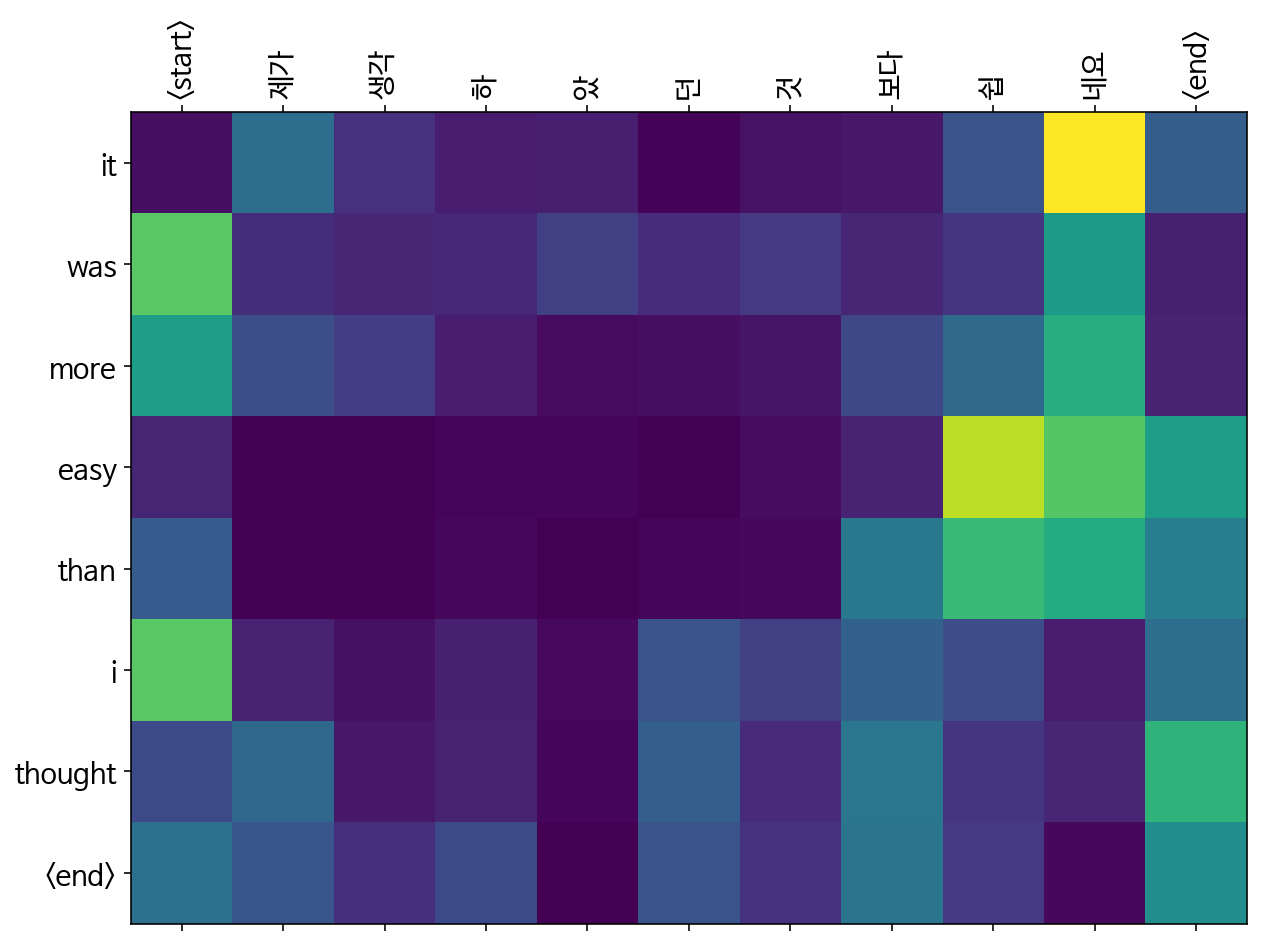

In [42]:
translate("제가 생각했던 것보다 쉽네요")

추론 결과를 한 단계씩 살펴보겠습니다.   
먼저 인풋 문장은 토크나이징하여 [<start\>] [제가] [생각] [하] [았] [던] [것] [보다] [쉽] [네요] [\<end\>]로 처리되었습니다.   

👉 첫 번째 토큰으로 [it]가 디코딩되었고, 이때 [네요] 토큰에 attention score이 높았습니다.   
👉 두 번째 토큰은 Input feeding으로 [it]이 디코더에 들어가 [was] 토큰이 디코딩되었고, [<start\>]와 [네요] 토큰에 attention score이 높았습니다.  
👉 세 번째 토큰은 [more]이 디코딩되었고  [보다] [쉽] [네요] 등에 골고루 attend했습니다.   
👉 네 번째 토큰은 [easy]가 디코딩되었고 [쉽] [네요] 토큰에 score가 높습니다.   

...  

이런 식으로 디코딩 타음스텝별로 인풋 토큰 중 필요한 부분에 attend하여 필요한 문맥 정보를 가지고 옵니다.   

Input: <start> 이따 치킨 이랑 맥주 먹 어야지 <end>
Predicted translation: we have to eat a beer and chicken <end> 


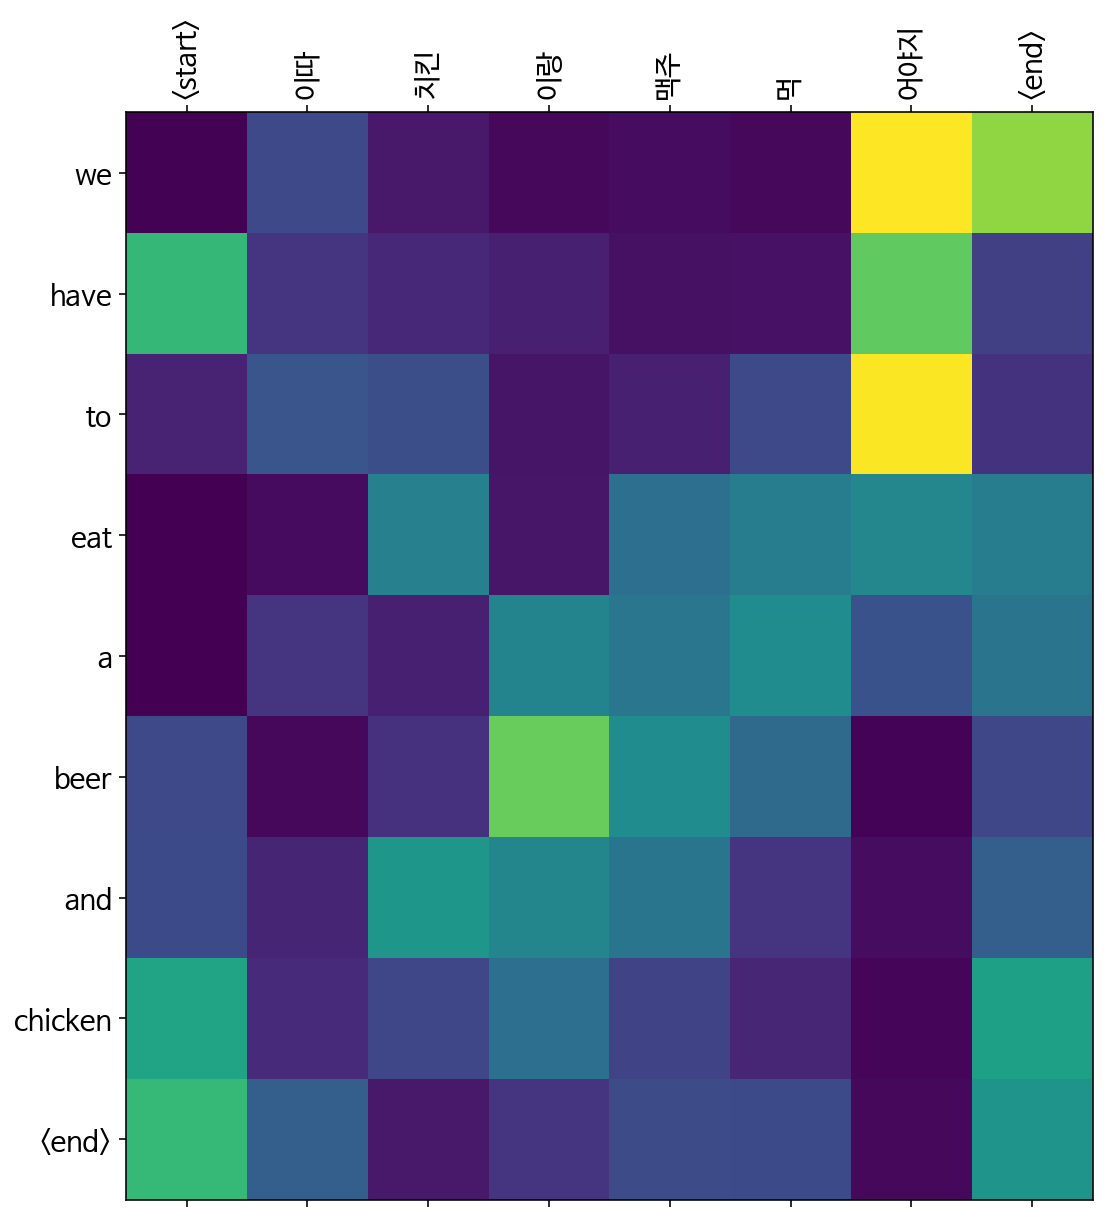

In [43]:
translate("이따 치킨이랑 맥주 먹어야지")

두 번째 문장에 대해서도 결과를 한 번 확인해 보시기 바랍니다.   
한국어와 영어는 어순이 역순이어서 그런지, attention score가 역순으로 점수가 높은 것도 보여서 재미있는 결과입니다.  

Input: <start> 편하 ㄴ 방향 으로 정하 아 지 겠 지 <end>
Predicted translation: would you like to go to the temple <end> 


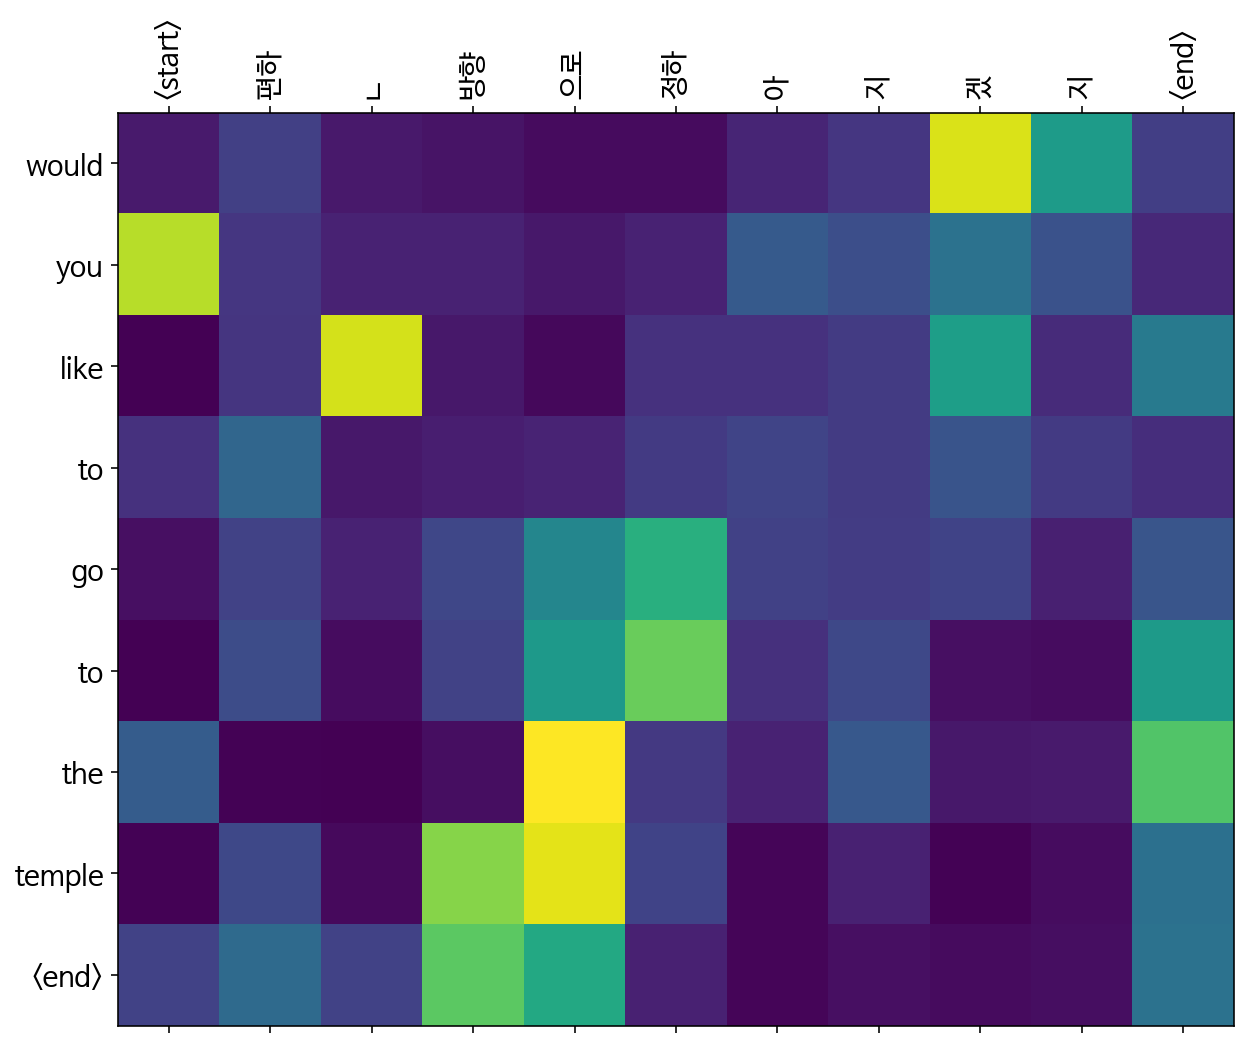

In [46]:
translate("편한 방향으로 정해지겠지")